In [1]:
pip install -U segmentation-models

     |████████████████████████████████| 50 kB 4.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/my-drive')

Mounted at /my-drive


In [ ]:
pip install -U segmentation-models

     |████████████████████████████████| 50 kB 5.9 MB/s 


In [3]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [4]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 17

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip /content/drive/MyDrive/image/archive.zip

Archive:  /content/drive/MyDrive/image/archive.zip
  inflating: README.html             
  inflating: README.md               
  inflating: calibrations/00_000200.txt  
  inflating: calibrations/00_000400.txt  
  inflating: calibrations/00_000600.txt  
  inflating: calibrations/00_000800.txt  
  inflating: calibrations/00_001000.txt  
  inflating: calibrations/00_001200.txt  
  inflating: calibrations/00_001400.txt  
  inflating: calibrations/00_001600.txt  
  inflating: calibrations/00_001800.txt  
  inflating: calibrations/00_002000.txt  
  inflating: calibrations/00_002200.txt  
  inflating: calibrations/00_002400.txt  
  inflating: calibrations/00_002600.txt  
  inflating: calibrations/00_002800.txt  
  inflating: calibrations/00_003000.txt  
  inflating: calibrations/00_003200.txt  
  inflating: calibrations/00_003400.txt  
  inflating: calibrations/00_003600.txt  
  inflating: calibrations/00_003800.txt  
  inflating: calibrations/00_004000.txt  
  inflating: calibrations/00_0042

In [8]:
train_images = []
TRAINING_DIR = "/content/"
filenames= sorted(glob(os.path.join(TRAINING_DIR, "images/*.png")))

for image_path in filenames:
    img = tf.io.read_file(image_path)
    image = tf.image.decode_png(img, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255
    train_images.append(image)
train_images = np.array(train_images) 
print(train_images.shape)

(208, 256, 256, 3)


In [9]:
train_masks = []
TRAINING_MASK_DIR  = "/content/"
filenames= sorted(glob(os.path.join(TRAINING_MASK_DIR, "labels_new/*.png")))

for mask_path in filenames:
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask.set_shape([None, None, 3])
    mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE])
    train_masks.append(mask)
train_masks = np.array(train_masks) 
print(train_masks.shape)

(208, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


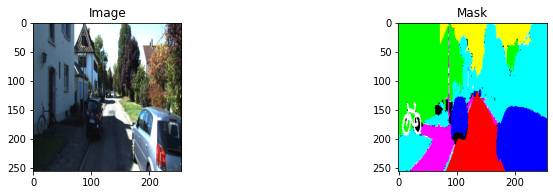

In [10]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]


plt.figure(figsize=(12,6))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [11]:
Car=	( 0, 0,255)	
Road=(255, 0, 0)	
Mark=	(255,255, 0)	
Building=	( 0,255, 0)	
Sidewalk=	(255, 0,255)	
Tree_Bush=	( 0,255,255)	
Pole	=(255, 0,153)
Sign	=(153, 0,255)	
Person=	( 0,153,255)	
Wall	=(153,255, 0)	
Sky	=(255,153,0)
Curb=	( 0,255,153)	
Grass_Dirt=	( 0,153,153)
Void	=( 0, 0, 0)	
Side_rail=	(153,153,153)
Object=	( 0, 0,153)
Bicycle_Motorbike=	(255,255,153)

In [12]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Car,axis=-1)] = 0
    label_seg [np.all(label==Road,axis=-1)] = 1
    label_seg [np.all(label==Mark,axis=-1)] = 2
    label_seg [np.all(label==Building,axis=-1)] = 3
    label_seg [np.all(label==Sidewalk,axis=-1)] = 4
    label_seg [np.all(label==Tree_Bush,axis=-1)] = 5
    label_seg [np.all(label == Pole,axis=-1)] = 6
    label_seg [np.all(label==Sign,axis=-1)] = 7
    label_seg [np.all(label==Person,axis=-1)] = 8
    label_seg [np.all(label==Wall,axis=-1)] = 9
    label_seg [np.all(label==Sky,axis=-1)] = 10
    label_seg [np.all(label==Curb,axis=-1)] = 11
    label_seg [np.all(label == Grass_Dirt,axis=-1)] = 12
    label_seg [np.all(label==Void,axis=-1)] = 13
    label_seg [np.all(label==Side_rail,axis=-1)] = 14
    label_seg [np.all(label==Object,axis=-1)] = 15
    label_seg [np.all(label==Bicycle_Motorbike,axis=-1)] = 16
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [13]:
labels = []
for i in range(train_masks.shape[0]):
    label = rgb_to_2D_label(train_masks[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [14]:
labels.shape

(208, 256, 256, 1)

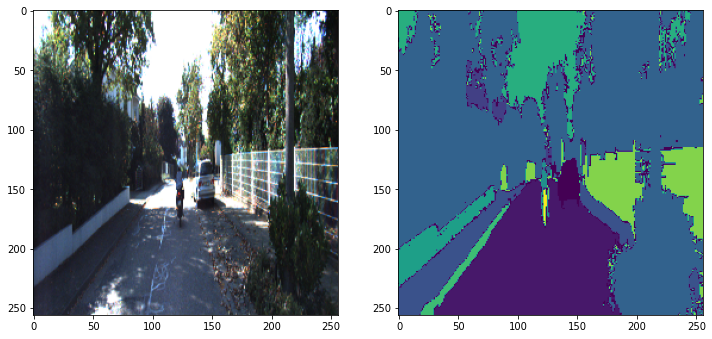

In [15]:
#Another Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(train_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_images[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [16]:
###################
#Convert labeled images back to original RGB colored masks. 

def label_to_rgb(predicted_image):    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Car
    segmented_img[(predicted_image == 1)] = Road
    segmented_img[(predicted_image == 2)] = Mark
    segmented_img[(predicted_image == 3)] = Building
    segmented_img[(predicted_image == 4)] = Sidewalk
    segmented_img[(predicted_image == 5)] = Tree_Bush
    segmented_img[(predicted_image == 6)] = Pole
    segmented_img[(predicted_image == 7)] = Sign
    segmented_img[(predicted_image == 8)] = Person
    segmented_img[(predicted_image == 9)] = Wall
    segmented_img[(predicted_image == 10)] = Sky
    segmented_img[(predicted_image == 11)] = Curb
    segmented_img[(predicted_image == 12)] = Grass_Dirt
    segmented_img[(predicted_image == 13)] = Void
    segmented_img[(predicted_image == 14)] = Side_rail
    segmented_img[(predicted_image == 15)] = Object
    segmented_img[(predicted_image == 16)] = Bicycle_Motorbike
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


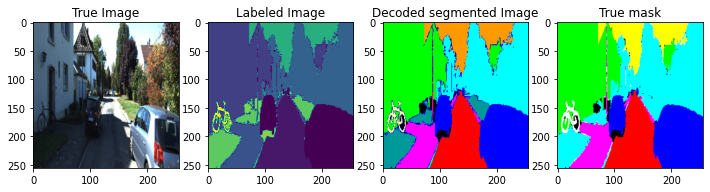

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(241)
plt.title('True Image')
plt.imshow(train_images[img_number])
plt.subplot(242)
plt.title('Labeled Image')
plt.imshow(labels[img_number][:,:,0])
plt.subplot(243)
plt.title('Decoded segmented Image')
plt.imshow(label_to_rgb(labels[img_number][:,:,0]))
plt.subplot(244)
plt.title('True mask')
plt.imshow(mask)
plt.show()

In [18]:
#Train_Test_Split
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, labels_cat, test_size = 0.10, random_state = 42)

In [19]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [20]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
# batch_size=100

from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=40.,
                          #  width_shift_range=0.1,
                          #  height_shift_range=0.1,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode='nearest')

mask_data_gen_args = dict(rotation_range=40.,
                          #  width_shift_range=0.1,
                          #  height_shift_range=0.1,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode='nearest')

In [21]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (187, 256, 256, 17) (17 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (187, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 cha

In [22]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [23]:
train_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [24]:
x, y = train_generator.__next__()

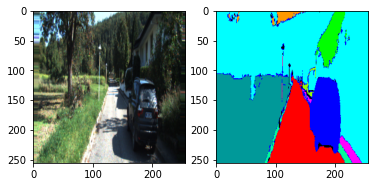

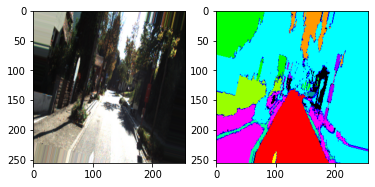

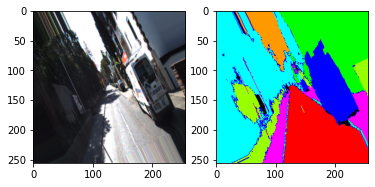

In [25]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(label_to_rgb(mask))
    plt.show()

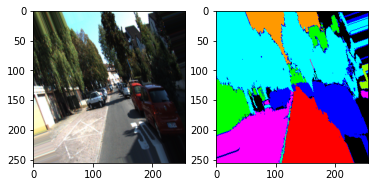

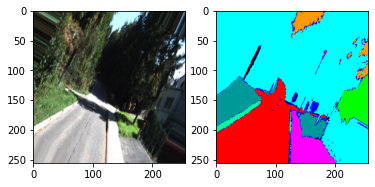

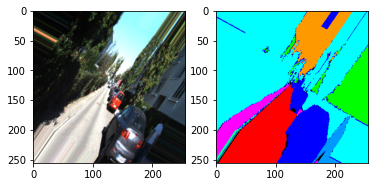

In [37]:
x, y = validation_datagen.__next__()
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(label_to_rgb(mask))
    plt.show()

In [26]:
from tensorflow.keras.optimizers import *
def multi_unet_model(n_classes=17, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s =  tf.keras.layers.Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 =  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 =  tf.keras.layers.Dropout(0.1)(c1)
    c1 =  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 =  tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 =  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 =  tf.keras.layers.Dropout(0.1)(c2)
    c2 =  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 =  tf.keras.layers.MaxPooling2D((2, 2))(c2)
     
    c3 =  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 =  tf.keras.layers.Dropout(0.2)(c3)
    c3 =  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 =  tf.keras.layers.MaxPooling2D((2, 2))(c3)
     
    c4 =  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 =  tf.keras.layers.Dropout(0.2)(c4)
    c4 =  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 =  tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 =  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 =  tf.keras.layers.Dropout(0.3)(c5)
    c5 =  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 =  tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 =  tf.keras.layers.concatenate([u6, c4])
    c6 =  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 =  tf.keras.layers.Dropout(0.2)(c6)
    c6 =  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 =  tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 =  tf.keras.layers.concatenate([u7, c3])
    c7 =  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 =  tf.keras.layers.Dropout(0.2)(c7)
    c7 =  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 =  tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 =  tf.keras.layers.concatenate([u8, c2])
    c8 =  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 =  tf.keras.layers.Dropout(0.1)(c8)
    c8 =  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 =  tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 =  tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 =  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 =  tf.keras.layers.Dropout(0.1)(c9)
    c9 =  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs =  tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

In [27]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH , IMG_CHANNELS=IMG_CHANNELS)

In [28]:
model = get_model()
model.compile(optimizer='adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [29]:
batch_size = 16
steps_per_epoch = 3*(len(X_train))//batch_size
print(steps_per_epoch)

35


In [ ]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
# model=multi_unet_model(17,256,256,3)
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)
#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 
history = model.fit(train_generator,validation_data=validation_datagen, steps_per_epoch=steps_per_epoch,validation_steps=steps_per_epoch,epochs=60)


model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

85532672/85521592 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

In [34]:
from tensorflow.keras.models import load_model
model = load_model('/content/landcover_25_epochs_RESNET_backbone_batch16 (4).hdf5',compile=False)

#Continue training
history = model.fit(train_generator,validation_data=validation_datagen, steps_per_epoch=steps_per_epoch,validation_steps=steps_per_epoch,epochs=5)

RuntimeError: ignored

In [58]:
model.save('landcover_40_epochs_RESNET_backbone_batch16.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

iou_score= history.history['iou_score']
val_iou_score = history.history['val_iou_score']

plt.plot(epochs, iou_score, 'y', label='iou_score')
plt.plot(epochs, val_iou_score, 'r', label='Validation Accuracy')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.legend()
plt.show()

NameError: ignored

In [36]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

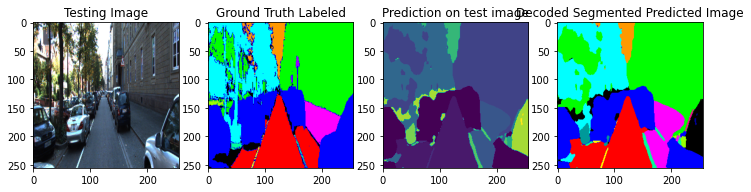

In [38]:
import random
test_img_number = random.randint(0, len(X_test))
ground_truth=np.argmax(y_test[test_img_number],axis=2)
pred_img = y_pred_argmax[test_img_number]

plt.figure(figsize=(12, 6))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(X_test[test_img_number])
plt.subplot(242)
plt.title('Ground Truth Labeled')
plt.imshow(label_to_rgb(ground_truth))
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(pred_img )
plt.subplot(244)
plt.title('Decoded Segmented Predicted Image')
plt.imshow(label_to_rgb(pred_img))
plt.show()

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
ground_truth=np.argmax(y_test[test_img_number],axis=2)
pred_img = y_pred_argmax[test_img_number]

plt.figure(figsize=(12, 6))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(X_test[test_img_number])
plt.subplot(242)
plt.title('Ground Truth Labeled')
plt.imshow(label_to_rgb(ground_truth))
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(pred_img )
plt.subplot(244)
plt.title('Decoded Segmented Predicted Image')
plt.imshow(label_to_rgb(pred_img))
plt.show()

In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 17
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth, pred_img)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
model.save('/content/drive/MyDrive/Our_Unet_Aug_semi_final.hdf5') #loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score]

In [ ]:
# def get_model():
#     return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# def unet(pretrained_weights = None,input_size=(256,256,3), n_class=3):
    
#     inputs = tf.keras.Input(shape=input_size)
#     conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = tf.keras.layers.BatchNormalization()(conv1)
#     conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     conv1 = tf.keras.layers.BatchNormalization()(conv1)
#     pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = tf.keras.layers.BatchNormalization()(conv2)
#     conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     conv2 = tf.keras.layers.BatchNormalization()(conv2)
#     pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = tf.keras.layers.BatchNormalization()(conv3)
#     conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     conv3 = tf.keras.layers.BatchNormalization()(conv3)
#     pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = tf.keras.layers.BatchNormalization()(conv4)
#     conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     conv4 = tf.keras.layers.BatchNormalization()(conv4)
#     drop4 = tf.keras.layers.Dropout(0.5)(conv4, training=True)
#     pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = tf.keras.layers.BatchNormalization()(conv5)
#     conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     conv5 = tf.keras.layers.BatchNormalization()(conv5)
#     drop5 = tf.keras.layers.Dropout(0.5)(conv5, training=True)

#     up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
#     conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

#     up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
#     conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

#     up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
#     conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

#     up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
#     conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
       
#     conv10 = tf.keras.layers.Conv2D(n_class, (1,1), activation = 'softmax')(conv9)
    
 
#     model = tf.keras.Model(inputs = inputs, outputs = conv10)

#     # model.compile(optimizer = Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics = ['accuracy'])
#     #model.compile(optimizer = Adam(lr = 0.0001), loss = [dice_coef_loss], metrics = [dice_coef])
    

#     if(pretrained_weights):
#     	model=keras.models.load_model(pretrained_weights)

#     return model

In [ ]:
# history = model.fit(X_train, y_train, 
#                     batch_size = BATCH_SIZE, 
#                     verbose=1, 
#                     epochs=60, 
#                     validation_data=(X_test, y_test), 
#                     workers = 4,
#                     use_multiprocessing = True,
#                     # callbacks = callbacks_list,
#                     shuffle=False)

Epoch 1/60
12/12 [==============================] - 9s 403ms/step - loss: -0.1664 - categorical_accuracy: 0.1756 - val_loss: -0.2651 - val_categorical_accuracy: 0.2651
Epoch 2/60
12/12 [==============================] - 4s 366ms/step - loss: -0.1757 - categorical_accuracy: 0.1757 - val_loss: -0.2651 - val_categorical_accuracy: 0.2651
Epoch 3/60
12/12 [==============================] - 4s 364ms/step - loss: -0.1757 - categorical_accuracy: 0.1757 - val_loss: -0.2651 - val_categorical_accuracy: 0.2651
Epoch 4/60
12/12 [==============================] - 4s 363ms/step - loss: -0.1757 - categorical_accuracy: 0.1757 - val_loss: -0.2651 - val_categorical_accuracy: 0.2651
Epoch 5/60
12/12 [==============================] - 4s 356ms/step - loss: -0.1757 - categorical_accuracy: 0.1757 - val_loss: -0.2651 - val_categorical_accuracy: 0.2651
Epoch 6/60
12/12 [==============================] - 4s 361ms/step - loss: -0.1757 - categorical_accuracy: 0.1757 - val_loss: -0.2651 - val_categorical_accuracy:

In [ ]:
# model.save('/content/gdrive/MyDrive/saved_models/Our_Unet_3.h5') #Metric ['categorical_accuracy']

1/1 [==============================] - 0s 286ms/step - loss: -0.2651 - categorical_accuracy: 0.2651
Accuracy is =  26.51258111000061 %


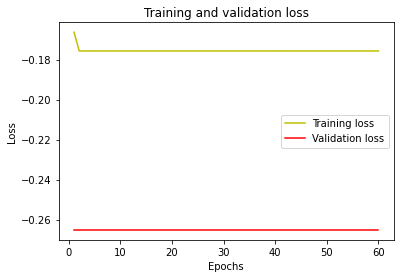

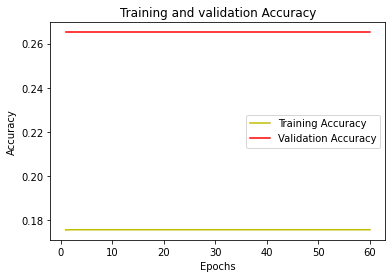

In [ ]:
# #Metric ['categorical_accuracy']
# #Evaluate the model

# _,acc = model.evaluate(X_test, y_test)
# print("Accuracy is = ", (acc*100), "%")

# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['categorical_accuracy']
# val_acc = history.history['val_categorical_accuracy']

# plt.plot(epochs, acc, 'y', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
# plt.title('Training and validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# #Metric ['categorical_accuracy']
# y_pred=model.predict(X_test)
# y_pred_argmax=np.argmax(y_pred, axis=3)

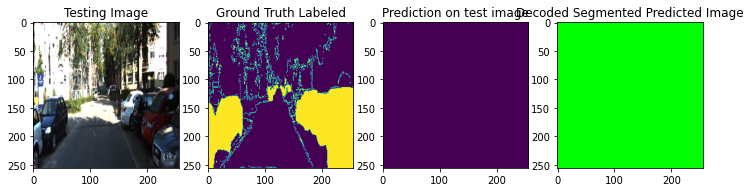

In [ ]:
# #Metric ['categorical_accuracy']
# import random
# test_img_number = random.randint(0, len(X_test))
# ground_truth_labeled=y_test[test_img_number]
# pred_img = y_pred_argmax[test_img_number]

# plt.figure(figsize=(12, 6))
# plt.subplot(241)
# plt.title('Testing Image')
# plt.imshow(X_test[test_img_number])
# plt.subplot(242)
# plt.title('Ground Truth Labeled')
# plt.imshow(ground_truth_labeled[:,:,0])
# plt.subplot(243)
# plt.title('Prediction on test image')
# plt.imshow(pred_img )
# plt.subplot(244)
# plt.title('Decoded Segmented Predicted Image')
# plt.imshow(decode_segmap(pred_img,color_dict))
# plt.show()

In [ ]:
# import tensorflow as tf
# from keras import backend as K
# # Define IoU metric
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec))

# smooth = 1.
# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

In [ ]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
# weight_path="{}_weights.best.hdf5".format('unet')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=5) # probably needs to be more patient, but kaggle time is limited
# callbacks_list = [checkpoint, early, reduceLROnPlat]

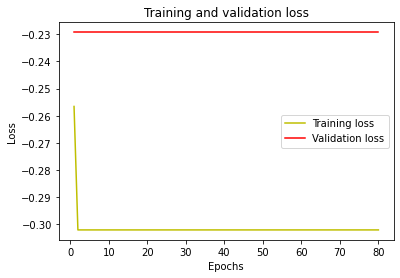

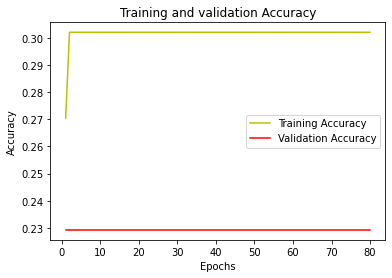

In [ ]:
#Metric [dice_coef, 'categorical_accuracy']
#Evaluate the model

# acc = model.evaluate(X_test, y_test)
# print("Accuracy is = ", (acc), "%")

# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['categorical_accuracy']
# val_acc = history.history['val_categorical_accuracy']

# plt.plot(epochs, acc, 'y', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
# plt.title('Training and validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# model.save('/content/gdrive/MyDrive/saved_models/Our_Unet_2.h5') #Metric [dice_coef, 'categorical_accuracy']

In [ ]:
#Metric [dice_coef, 'categorical_accuracy']
# y_pred=model.predict(X_test)
# y_pred_argmax=np.argmax(y_pred, axis=3)

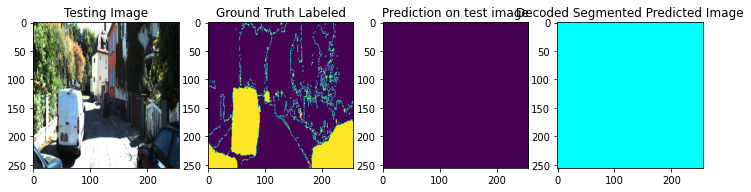

In [ ]:
#Metric [dice_coef, 'categorical_accuracy']
# import random
# test_img_number = random.randint(0, len(X_test))
# ground_truth_labeled=y_test[test_img_number]
# pred_img = y_pred_argmax[test_img_number]

# plt.figure(figsize=(12, 6))
# plt.subplot(241)
# plt.title('Testing Image')
# plt.imshow(X_test[test_img_number])
# plt.subplot(242)
# plt.title('Ground Truth Labeled')
# plt.imshow(ground_truth_labeled[:,:,0])
# plt.subplot(243)
# plt.title('Prediction on test image')
# plt.imshow(pred_img )
# plt.subplot(244)
# plt.title('Decoded Segmented Predicted Image')
# plt.imshow(decode_segmap(pred_img,color_dict))
# plt.show()